# CPE-221 Mini-Project: Laptop Price Prediction
- Dataset: Kaggle Laptop Price
- Authors: iamkuyik, Joseph Prince Aniekeme

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
df = pd.read_csv('../data/raw/laptop_price.csv', encoding='latin1')
print(df.shape)
df.head()

(1303, 13)


,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


In [ ]:
# Checking missing values
df.isna().sum()
# handle: df = df.dropna() OR impute

laptop_ID           0
Company             0
Product             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price_euros         0
dtype: int64

<Axes: >

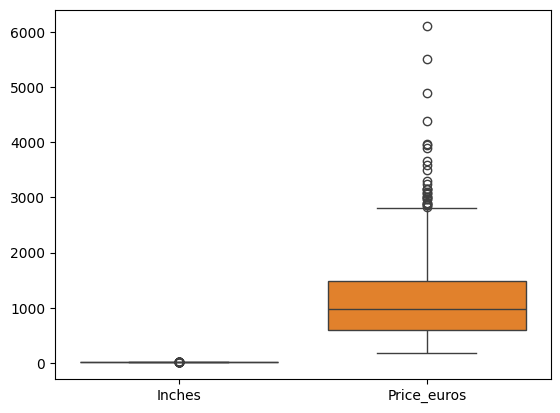

In [ ]:
# Checking for outliers
num_cols = ['Inches', 'Price_euros']
sns.boxplot(data=df[num_cols])

# there seem to be quite a few outliers on the Price_euros column, do we keep them?

## Convderting categorical features to numerical

In [ ]:
import re, pandas as pd, numpy as np
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder

In [ ]:
def extract_numeric(text, unit='GB'):
    """Pull the first numeric value from a string and scale by unit."""
    m = re.search(r'(\d+(?:\.\d+)?)', str(text))
    if not m:
        return np.nan
    val = float(m.group(1))
    if 'TB' in str(text):
        val *= 1000
    return val

In [ ]:
# using onehot to retain names of top 10 companies while saving the rest as 'Other'
top10 = df['Company'].value_counts().nlargest(10).index
df['Company_enc'] = df['Company'].where(df['Company'].isin(top10), 'Other')
company_ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
company_ohe_df = pd.DataFrame(
    company_ohe.fit_transform(df[['Company_enc']]),
    columns=company_ohe.get_feature_names_out(['Company_enc'])
)

In [ ]:
# Product is ~1000 levels, mostly noise for linear model
df = df.drop(columns=['Product'])

In [ ]:
type_ohe = OneHotEncoder(sparse_output=False)
type_ohe_df = pd.DataFrame(
    type_ohe.fit_transform(df[['TypeName']]),
    columns=type_ohe.get_feature_names_out(['TypeName'])
)

In [ ]:
# a) Extract brand
df['Cpu_Brand'] = df['Cpu'].str.extract(r'^(Intel|AMD|Apple)', expand=False).fillna('Other')

# b) Now that the column exists, fit/encode
cpu_brand_ohe = OneHotEncoder(sparse_output=False)
cpu_brand_df = pd.DataFrame(
    cpu_brand_ohe.fit_transform(df[['Cpu_Brand']]),
    columns=cpu_brand_ohe.get_feature_names_out(['Cpu_Brand'])
)

In [ ]:
# b) Extract clock speed (GHz)
df['Cpu_Clock'] = df['Cpu'].str.extract(r'([\d\.]+)\s*GHz')
df['Cpu_Clock'] = pd.to_numeric(df['Cpu_Clock'], errors='coerce')

In [ ]:
# c) Extract tier (i3/i5/i7, Ryzen 3/5/7, etc.)
tier_map = {
    'i3': 1, 'i5': 2, 'i7': 3, 'i9': 4,
    'M1': 3, 'M2': 4,
    'Ryzen 3': 1, 'Ryzen 5': 2, 'Ryzen 7': 3, 'Ryzen 9': 4
}

df['Cpu_Tier'] = (
    df['Cpu']
      .str.extract(r'(i\d|M\d|Ryzen \d)')[0]   # take the first (and only) group
      .map(tier_map)
      .fillna(1)
      .astype('int8')
)

In [ ]:
# Memory column
# a) SSD presence
df['SSD_Flag'] = df['Memory'].str.contains('SSD', case=False).astype(int)

# b) HDD presence
df['HDD_Flag'] = df['Memory'].str.contains('HDD', case=False).astype(int)

# c) Total storage GB (SSD + HDD)
storage_vals = df['Memory'].str.findall(r'(\d+)\s*(GB|TB)')
df['Storage_GB'] = storage_vals.apply(
    lambda lst: sum(extract_numeric(v[0] + v[1]) for v in lst)
)

In [ ]:
# GPU
# a) Brand
df['Gpu_Brand'] = df['Gpu'].str.extract(r'(Intel|Nvidia|AMD)', expand=False).fillna('Other')

# b) Tier (0 = integrated, 1 = entry discrete, 2 = mid, 3 = high)
tier_pattern = {
    'Intel': 0,
    'Radeon R[2345]': 1, 'Radeon R[67]': 2, 'Radeon RX': 3,
    'GeForce [9]20': 1, 'GeForce [9]30': 1, 'GeForce [9]40': 2,
    'GeForce GTX [9][5678]': 2, 'GeForce GTX 10[567]': 3,
    'GeForce GTX 1080': 4
}
df['Gpu_Tier'] = 0
for pat, tier in tier_pattern.items():
    mask = df['Gpu'].str.contains(pat, case=False)
    df.loc[mask, 'Gpu_Tier'] = tier

gpu_brand_ohe = OneHotEncoder(sparse_output=False)
gpu_brand_df = pd.DataFrame(
    gpu_brand_ohe.fit_transform(df[['Gpu_Brand']]),
    columns=gpu_brand_ohe.get_feature_names_out(['Gpu_Brand'])
)

In [ ]:
# Ram
df['Ram_GB'] = extract_numeric(df['Ram'], unit='GB')

In [ ]:
# OpSys

top5_os = df['OpSys'].value_counts().nlargest(5).index
df['OpSys_enc'] = df['OpSys'].where(df['OpSys'].isin(top5_os), 'Other')

os_ohe = OneHotEncoder(sparse_output=False)
os_ohe_df = pd.DataFrame(
    os_ohe.fit_transform(df[['OpSys_enc']]),
    columns=os_ohe.get_feature_names_out(['OpSys_enc'])
)

In [ ]:
# Weight
df['Weight_kg'] = pd.to_numeric(
    df['Weight'].str.replace('kg', ''), errors='coerce'
)

In [ ]:
# ScreenResolution
# a) Extract resolution
res = df['ScreenResolution'].str.extract(r'(\d+)x(\d+)')
df['Screen_W'] = pd.to_numeric(res[0], errors='coerce')
df['Screen_H'] = pd.to_numeric(res[1], errors='coerce')

# b) PPI = diagonal pixels / diagonal inches
diagonal_px = np.sqrt(df['Screen_W']**2 + df['Screen_H']**2)
df['PPI'] = diagonal_px / df['Inches']

In [ ]:
y = df['Price_euros']

In [ ]:
X = pd.concat([
    df[['Inches', 'Ram_GB', 'Storage_GB', 'Cpu_Clock', 'Cpu_Tier',
        'Gpu_Tier', 'SSD_Flag', 'HDD_Flag', 'Weight_kg', 'Screen_W',
        'Screen_H', 'PPI']],
    company_ohe_df,
    type_ohe_df,
    cpu_brand_df,
    gpu_brand_df,
    os_ohe_df
], axis=1)

# Save
X.to_csv('../data/processed/X_encoded.csv', index=False)
y.to_csv('../data/processed/y.csv', index=False, header=['Price'])

In [ ]:
print(X.shape)

(1303, 42)
